In [6]:
# THIS MODEL IS BUILT TO OVERFIT

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim

import pickle
import matplotlib.pyplot as plt

import os
import glob

In [7]:
def see_images(imgs, labels):
    plt.figure(figsize = (10,5*len(imgs)))
    for i, img in enumerate(imgs):
      img = np.array((img / img.max()) * 255).astype(np.uint8)
      plt.subplot(int("1" + str(len(imgs) + 1) + str(i+1)))
      plt.imshow(img)
      plt.title(labels[i])
    plt.show()


def see_images_lr(left_image, right_image):
    plt.figure()
    plt.subplot(121)
    plt.imshow(np.array(left_image * 255).astype(np.uint8), interpolation='none')
    plt.subplot(122)
    plt.imshow(np.array(right_image * 255).astype(np.uint8), interpolation='none')
    plt.show()

def unpack_pickle(path_with_file_name):
    x = y = None
    with open(path_with_file_name, 'rb') as pickle_file:
        data = pickle.load(pickle_file)
        x = data[0]
        y = data[1]
        # Need to take out empty array in x set, since there is a left over array on the left side of the list for each image (see comment at top of file)
        x = [temp[1] for temp in x]
    return x, y

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
#os.chdir('/content/drive/Shareddrives/ECE_792_Advanced_Topics_in_ML/compressed_images')
# os.chdir('/content/drive/MyDrive/Adv. ML')


Train Image


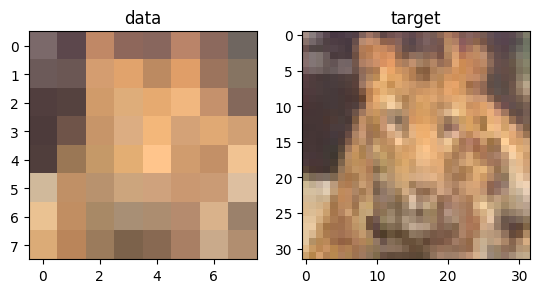

X Train Image Shape: (8, 8, 3)
Y Train Image Shape: (32, 32, 3)
Valid Image


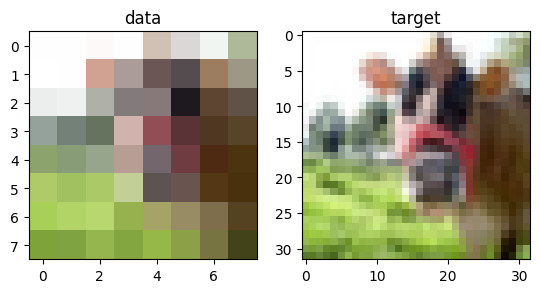

X Valid Image Shape: (8, 8, 3)
Y VaLid Image Shape: (32, 32, 3)
Test Image


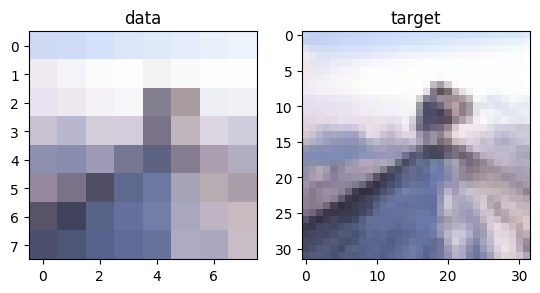

X Test Image Shape: (8, 8, 3)
Y Test Image Shape: (32, 32, 3)


In [10]:
# Unpickle Data
path = "./compressed_images/cifar-data/"
train_file_path = path + "train_32_16_4_8.dat"
valid_file_path = path + "valid_32_16_4_8.dat"
test_file_path = path + "test_32_16_4_8.dat"
x_train, y_train = unpack_pickle(train_file_path)
x_valid, y_valid = unpack_pickle(valid_file_path)
x_test, y_test = unpack_pickle(test_file_path)

# # downsize number of images
# x_train, y_train = x_train[:10], y_train[:10]
# x_valid, y_valid = x_valid[:10], y_valid[:10]
# x_test, y_test = x_test[:10], y_test[:10]


print("Train Image")
see_images([x_train[0], y_train[0]], ["data", "target"])
x_image_shape = x_train[0].shape
y_image_shape = y_train[0].shape
print("X Train Image Shape:", x_image_shape)
print("Y Train Image Shape:", y_image_shape)

print("Valid Image")
see_images([x_valid[0], y_valid[0]], ["data", "target"])
x_image_shape = x_valid[0].shape
y_image_shape = y_train[0].shape
print("X Valid Image Shape:", x_image_shape)
print("Y VaLid Image Shape:", y_image_shape)


print("Test Image")
see_images([x_test[0], y_test[0]],["data", "target"])
x_image_shape = x_test[0].shape
y_image_shape = y_test[0].shape
print("X Test Image Shape:", x_image_shape)
print("Y Test Image Shape:", y_image_shape)






In [11]:
# Need to resize the numpy array, since Conv2D expects (number, rgb channels, x, y)

def prepare_data_for_dataset(x, y):
    x = np.stack( x, axis=0)
    x = x.swapaxes(1, 3)
    y = np.stack( y, axis=0)
    y = y.swapaxes(1, 3)
    return x, y

x_train, y_train = prepare_data_for_dataset(x_train, y_train)
print("x_train new dimensions:", x_train.shape)
print("y_train new dimensions:", y_train.shape)

x_valid, y_valid = prepare_data_for_dataset(x_valid, y_valid)
print("x_valid new dimensions:", x_valid.shape)
print("y_valid new dimensions:", y_valid.shape)

x_test, y_test = prepare_data_for_dataset(x_test, y_test)
print("x_test new dimensions:", x_valid.shape)
print("y_test new dimensions:", y_valid.shape)

x_train new dimensions: (45000, 3, 8, 8)
y_train new dimensions: (45000, 3, 32, 32)
x_valid new dimensions: (5000, 3, 8, 8)
y_valid new dimensions: (5000, 3, 32, 32)
x_test new dimensions: (5000, 3, 8, 8)
y_test new dimensions: (5000, 3, 32, 32)


In [12]:
# Need to take images and place into dataset for easier use of data loader
class CompressionDataset(Dataset):
    def __init__(self, compressed_images, original_images, transforms=None) -> None:
        
        # scale input from 0 to 1
        self.original = original_images/255
        self.compressed = compressed_images/255
        
        
        if transforms != None: 
            for transform in transforms:
                self.original = transform(self.original)
                self.compressed = transform(self.compressed)
        super().__init__()
    def __len__(self):
        return len(self.original)
    def __getitem__(self, index):
        original_image = self.original[index]
        compressed_image = self.compressed[index]
        sample = {"Compressed":compressed_image, "Original":original_image}
        return sample


def ToTensor(array):
    return torch.from_numpy(array).float()


Train Image <class 'torch.Tensor'>
Test Image <class 'torch.Tensor'>
tensor(0.3373) tensor(0.6971)


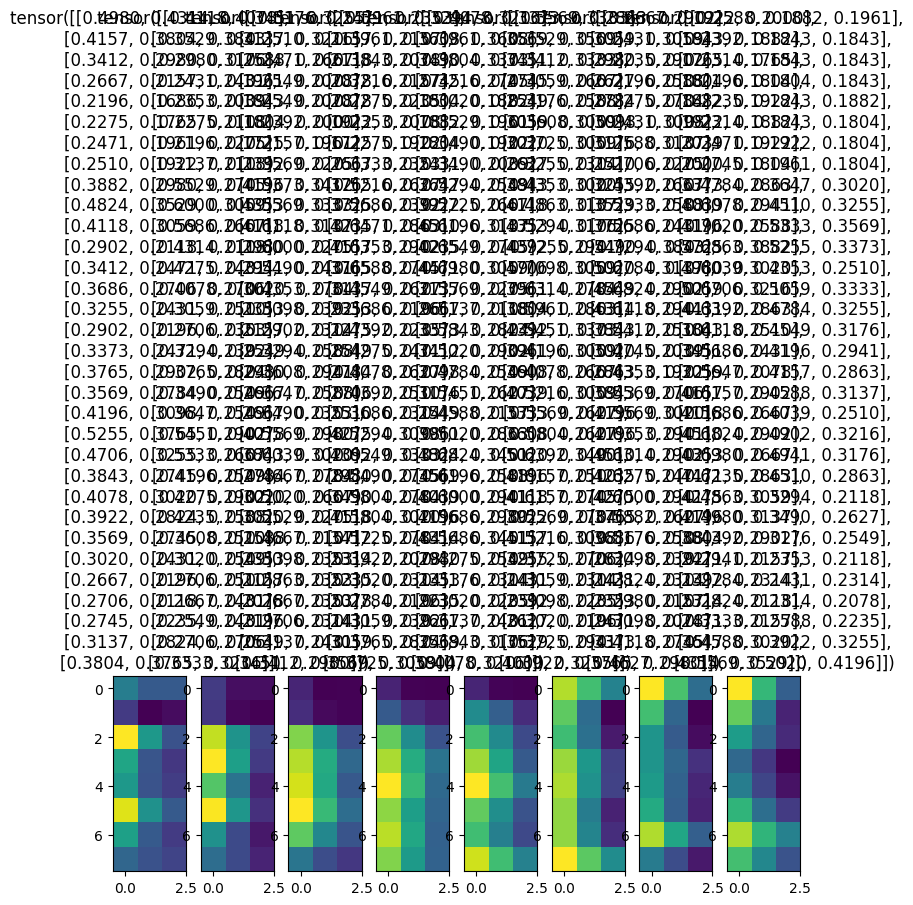

test tensor(0.8179)


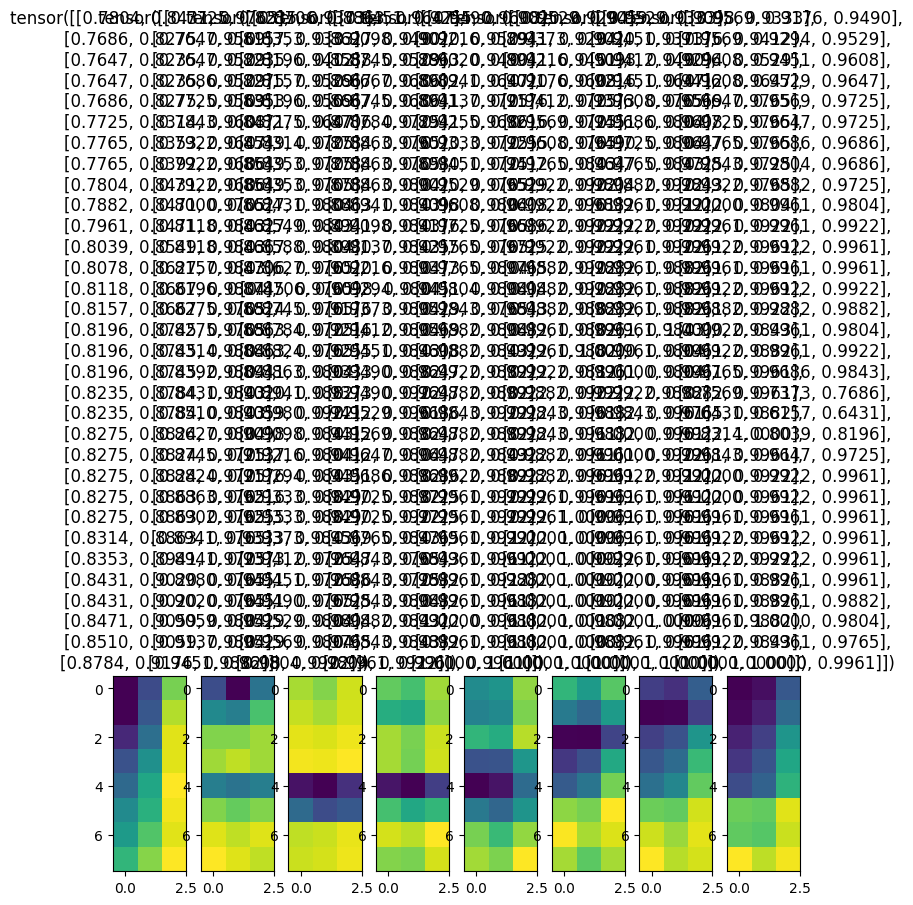

In [13]:

# Convert each set of images to a dataset

train_data_set = CompressionDataset(x_train, y_train, transforms= [ToTensor])
valid_data_set = CompressionDataset(x_valid, y_valid, transforms=[ToTensor])
test_data_set = CompressionDataset(x_test, y_test, transforms=[ToTensor])
batch_size = 32

image = train_data_set.compressed[0]

print("Train Image", type(image[0][0][0]))

image = test_data_set.compressed[0]
print("Test Image", type(image[0][0][0]))

train_data_loader = DataLoader(train_data_set, batch_size=batch_size, shuffle=False)
valid_data_loader = DataLoader(valid_data_set, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_data_set, batch_size=batch_size, shuffle=False)

#Testing Data Loader to see if it got our data correctly
for (idx, batch) in enumerate(train_data_loader):
    print(batch["Compressed"][0][0][0][0], batch["Compressed"][0].max())
    see_images(batch["Compressed"][0].swapaxes(0, 2), batch["Original"][0].swapaxes(0, 2))
    break # We just want first image in batch

for (idx, batch) in enumerate(test_data_loader):
    print("test",batch["Compressed"][0][0][0][0])
    see_images(batch["Compressed"][0].swapaxes(0, 2), batch["Original"][0].swapaxes(0, 2))
    break # We just want first image in batch

In [14]:
class Residual_Model(nn.Module):
    def __init__(self) -> None:
        super(Residual_Model, self).__init__()
        self.up_2x = nn.Upsample(scale_factor = 2, mode='nearest')

        # do a convtranspose2d????
        self.conv1 = nn.Conv2d(3, 16, 2, padding = 'same')
        self.batchnorm1 = nn.BatchNorm2d(16)

        self.upconv1 =  nn.ConvTranspose2d(16, 64, 2, stride=2, padding=0)
        # concatenate upsampled
        self.batchnorm2 = nn.BatchNorm2d(64 + 3)

        self.conv2 = nn.Conv2d(64 + 3, 128, 2, padding = 'same')
        self.batchnorm3 = nn.BatchNorm2d(128)

        self.upconv2 = nn.ConvTranspose2d(128, 32, 2, stride=2, padding=0)
        # concatenate upsampled
        self.batchnorm4 = nn.BatchNorm2d(32 + 3)

        self.conv3 = nn.Conv2d(32+3, 3, 2, padding = 'same')

        # self.batchnorm1 = nn.BatchNorm2d(40) 
        # self.batchnor
        m2 = nn.BatchNorm2d(3)

# https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11#:~:text=Transposed%20convolutions%20are%20standard%20convolutions,in%20a%20standard%20convolution%20operation.
    def forward(self, x):
        # convolve 
        input = x
        x = self.batchnorm1(func.relu(self.conv1(x)))

        # upconv and concatenate upsampled 
        print(torch.cat((self.up_2x(input), self.upconv1(x)), dim=1).shape)
        x = torch.cat((self.up_2x(input), self.upconv1(x)), dim=1)
        x = self.batchnorm2(func.relu(x))

        # convolve
        x = self.batchnorm3(func.relu(self.conv2(x)))

        # up conv and concatenate upsampled
        x = torch.cat((self.up_2x(self.up_2x(input)), self.upconv2(x)), dim=1)
        x = self.batchnorm4(func.relu(x))

        x = func.relu(self.conv3(x))
        return func.softmax(x)

# Test to see if it was working! 
for (idx, batch) in enumerate(train_data_loader):
    in_image = batch["Compressed"]
    test_net = Residual_Model()
    test_image = test_net.forward(in_image)
    # print(test_image)
    break


torch.Size([32, 67, 16, 16])


c:\Users\trent\Documents\ncstate_grad\ECE_792\ece792project\t-venv\lib\site-packages\torch\nn\modules\conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:896.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\trent\AppData\Local\Temp\ipykernel_10308\3777985696.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return func.softmax(x)


In [15]:
class Dense_Connection_Model(nn.Module):
    # https://www.analyticsvidhya.com/blog/2021/05/deep-learning-for-image-super-resolution/#:~:text=Super%2DResolution%20Generative%20Adversarial%20Network,match%20the%20true%20training%20data.
    # option (d) from above
    # arXiv:1501.00092v3 [cs.CV] 31 Jul 2015 -> simple (used this one)
    # arXiv:1707.02921v1 [cs.CV] 10 Jul 2017 -> complex


    def __init__(self) -> None:
        super(Dense_Connection_Model, self).__init__()
        self.up_2x = nn.Upsample(scale_factor = 4, mode='bicubic')

        self.cnn1 = nn.Conv2d(3, 64, 9, padding = 'same')
        self.cnn2 = nn.Conv2d(64, 32, 1, padding = 'same')
        self.output = nn.Conv2d(32, 3, 5, padding = 'same')
        
    def forward(self, x):
        x = self.up_2x(x)
        x = func.relu(self.cnn1(x))
        x = func.relu(self.cnn2(x))
        return self.output(x)

# Test to see if it was working! 
for (idx, batch) in enumerate(train_data_loader):
    in_image = batch["Compressed"]
    test_net = Dense_Connection_Model()
    test_image = test_net.forward(in_image)
    # print(test_image)
    break


In [16]:
img = batch["Compressed"][0]#.swapaxes(0, 2)
img = torch.reshape(img, (1, 3, 8, 8))
print(img.shape)
up = nn.Upsample(scale_factor = 4, mode='bicubic')


torch.Size([1, 3, 8, 8])


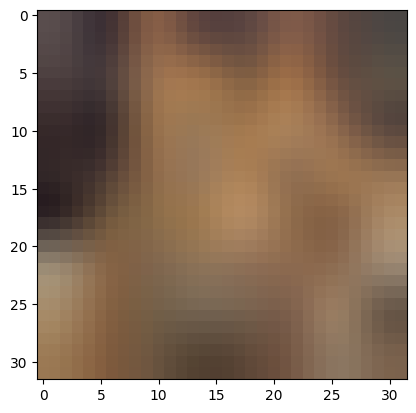

In [17]:
plt.imshow(torch.reshape(up(img), (3, 32, 32)).swapaxes(0,2))

In [18]:
# from torchsummary import summary

# vgg = Dense_Connection_Model()
# summary(vgg, (3, 8, 8))


In [19]:
# Ripped this part off of (will make a custom one later): https://nextjournal.com/gkoehler/pytorch-mnist
train_losses = []
train_counter = []
test_losses = []
n_epochs = 5
momentum = 0.5
learning_rate = 0.1
log_interval = 10
network = Dense_Connection_Model()
test_counter = [i*len(train_data_loader.dataset) for i in range(n_epochs + 1)]
optimizer = optim.Adam(network.parameters())



In [20]:


def train(epoch):
  network.train()
  for idx, batch in enumerate(train_data_loader):
    optimizer.zero_grad()
    output = network(batch["Compressed"])
    loss_func = nn.MSELoss()
    loss = loss_func(output, batch["Original"])
    loss.backward()
    optimizer.step()
    if idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, idx * len(batch["Compressed"]), len(train_data_loader.dataset),
        100. * idx / len(train_data_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (idx*64) + ((epoch-1)*len(train_data_loader.dataset)))
      torch.save(network.state_dict(), './trained_model/dense_test.pth')

def test(): # Need to figure out how to evaluate based on loss
  network.eval()
  test_loss = 0
  correct = 0
  loss_func = nn.MSELoss(reduction='sum')
  with torch.no_grad():
    # for idx, batch in enumerate(test_data_loader):
    for idx, batch in enumerate(train_data_loader):

      output = network(batch["Compressed"])
      print("Loss:", loss_func(output,batch["Original"] ))
      for idx, image in enumerate(output):
        x = batch["Compressed"][idx].numpy().swapaxes(0, 2)
        y_hat = image.numpy().swapaxes(0, 2)
        y = batch["Original"][idx].numpy().swapaxes(0, 2)
        see_images([x, y_hat, y], ["x", "y_hat", "y"])
      break
  return 

Loss: tensor(29274.8867)


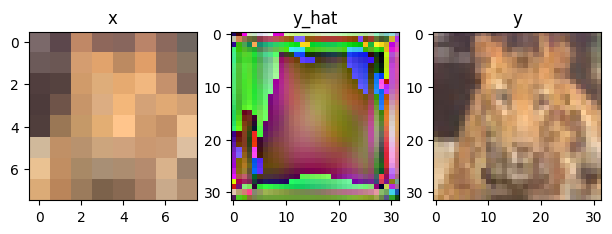

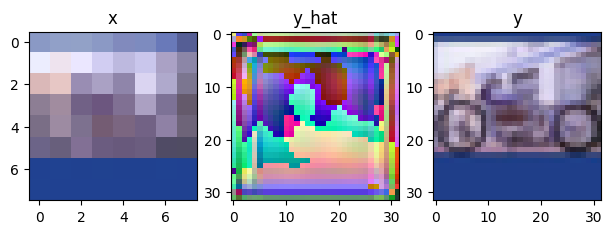

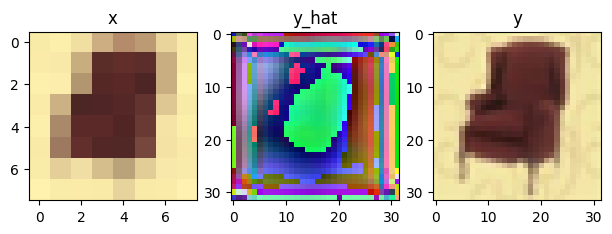

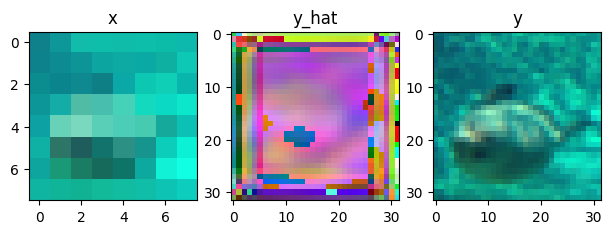

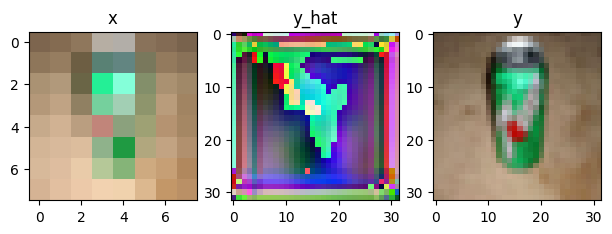

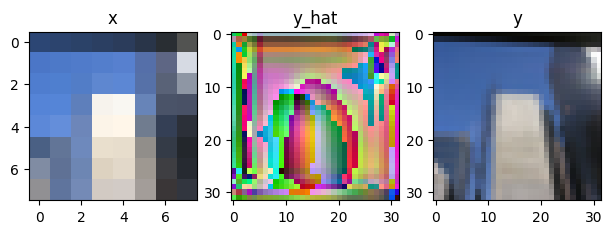

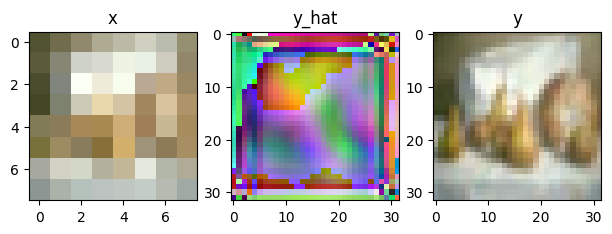

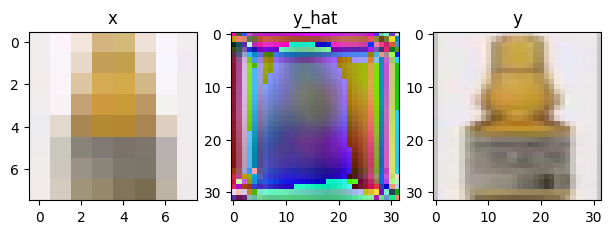

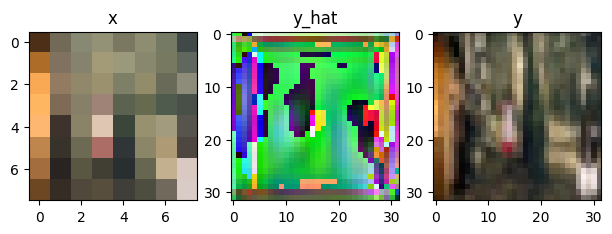

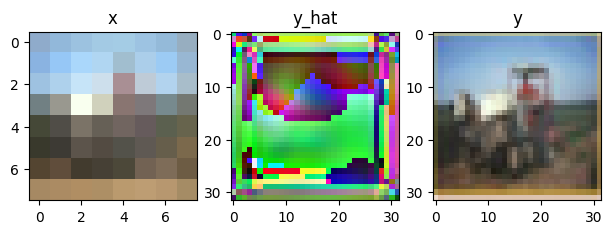

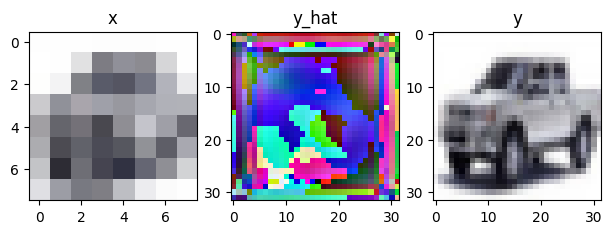

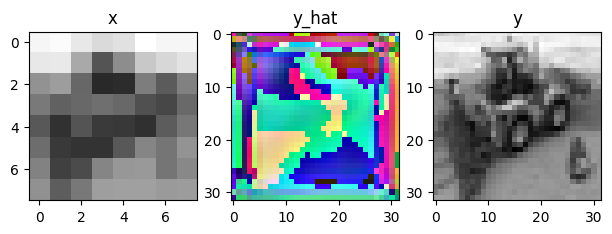

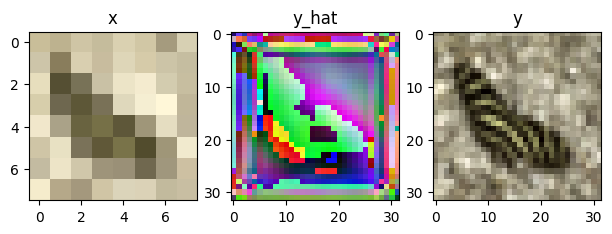

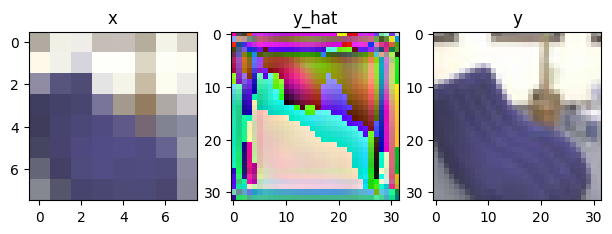

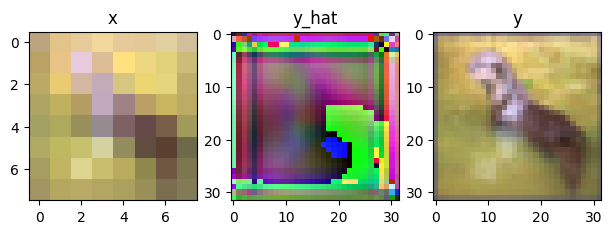

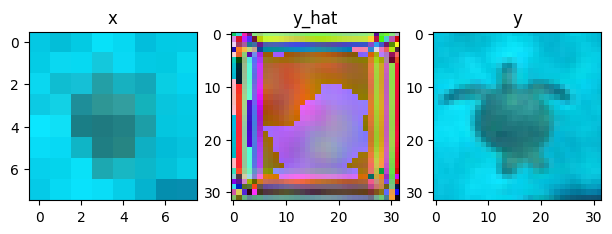

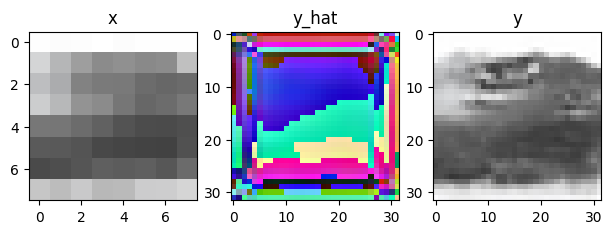

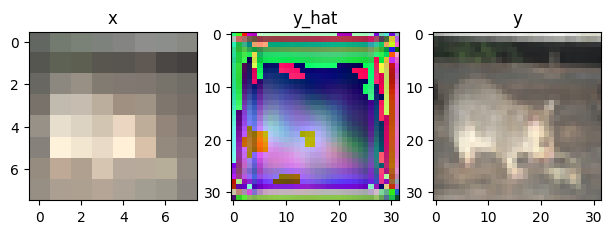

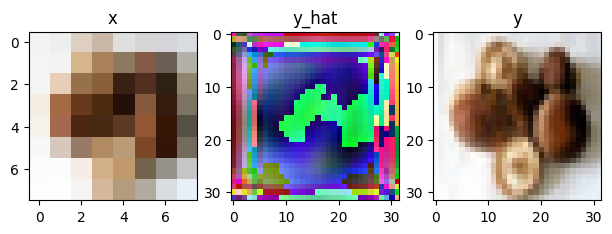

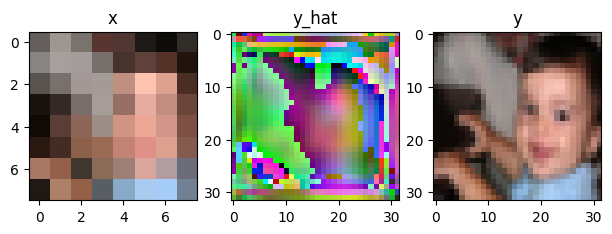

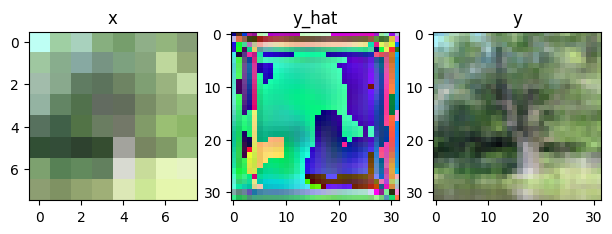

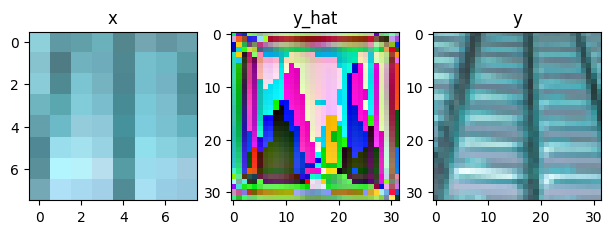

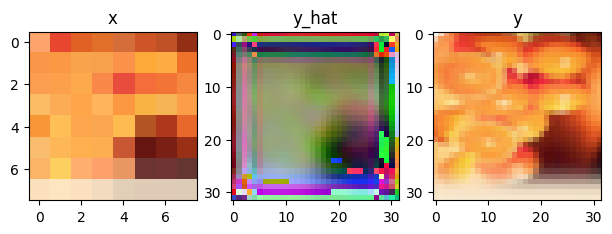

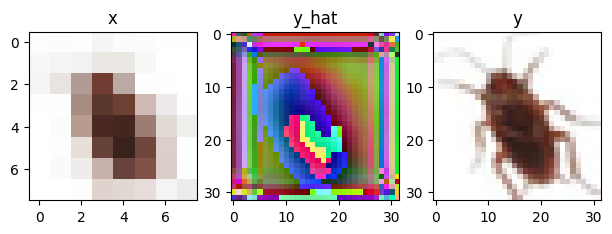

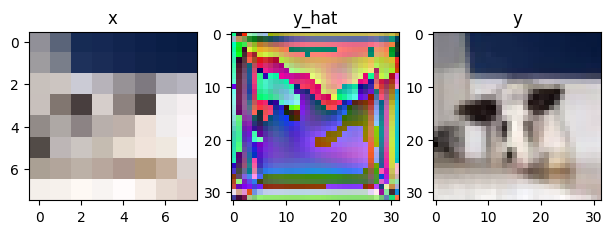

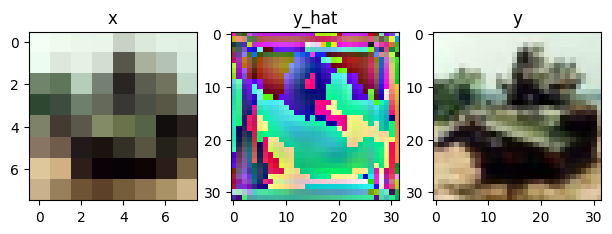

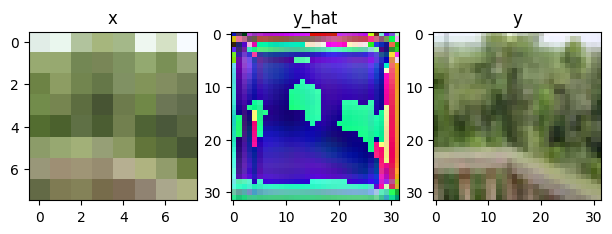

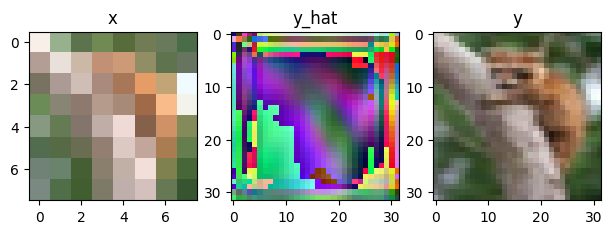

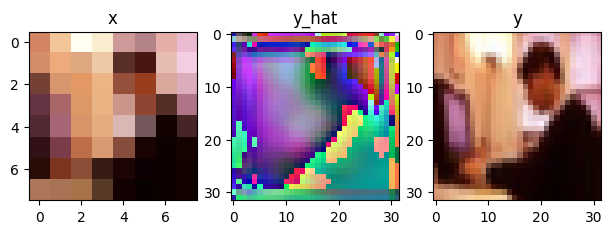

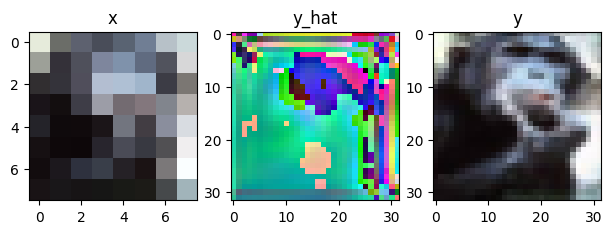

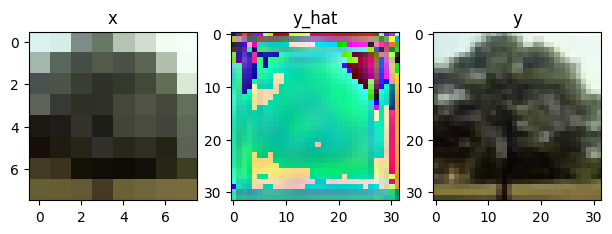

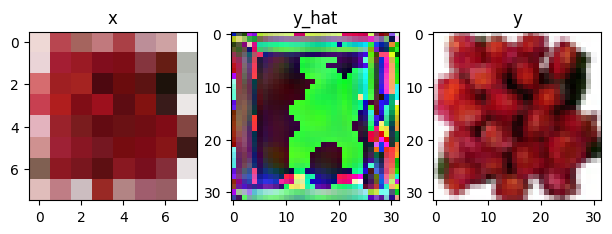

Train Epoch: 1 [0/45000 (0%)]	Loss: 0.297800


RuntimeError: Parent directory ./trained_model does not exist.

In [21]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
  # input() # DELETE THIS TO CONTINUE TRAINING!

In [ ]:
test()

In [ ]:
torch.save(network.state_dict(), "./dense_model")

In [ ]:
!pip install sewar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10599 sha256=e9958c00ff25e8af425a067da77c9fff01a97e03fe0a25d45cafd8a118a13445
  Stored in directory: /root/.cache/pip/wheels/90/c1/d2/90faa299f5473d447a9a489377305840b7268c92b79bb5e000
Successfully built sewar


In [ ]:
import image_metrics as im
import importlib
importlib.reload(im)

suite = im.Benchmark_Suite()
losses,metrics, times = suite.dataset_performance(network,nn.MSELoss(reduction='sum'),train_data_loader,stop=2,per_image=False)
print(np.array(losses))
print(metrics)
print("times", times)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[3161.1562 3158.3271 2807.323 ]
[[{'ergas': nan, 'mse': 903.8655598958334, 'psnr': 18.569765221374077, 'psnrb': 18.758080617661108, 'rase': nan, 'rmse': 30.064356967941844, 'sam': 0.2791792453879691, 'scc': 0.30596215152470435, 'uqi': nan}, {'ergas': nan, 'mse': 1502.5172526041667, 'psnr': 16.362608933926204, 'psnrb': 12.428841485358355, 'rase': nan, 'rmse': 38.76231743077504, 'sam': 0.30732643322088943, 'scc': 0.3211929859130555, 'uqi': nan}, {'ergas': nan, 'mse': 2893.2724609375, 'psnr': 13.516910275621331, 'psnrb': 7.813366261569944, 'rase': nan, 'rmse': 53.78914817077418, 'sam': 0.28633366157603657, 'scc': 0.07108009130684173, 'uqi': nan}, {'ergas': nan, 'mse': 2660.9778645833335, 'psnr': 13.88039098991943, 'psnrb': 12.115262099323571, 'rase': nan, 'rmse': 51.584666952335105, 'sam': 0.5214493735828751, 'scc': -0.16010785394425656, 'uqi': nan}, {'ergas': nan, 'mse': 1067.1494140625, 'psnr': 17.848551306093526, 'psnrb': 21.607433498029675, 'rase': nan, 'rmse': 32.667252931069974, 'sa